# Part II - Ford GoBike System (A Case of San Francisco Bay Area)
## by (Derrick Narkah)

## Investigation Overview

In this investigation, I wanted to find ways of improving the GoBike System by focusing more on the Bike Stations and other factors associated with the users of the system.

## Dataset Overview

The Ford GoBike System Data is data collected on 183413 individual rides made in a bike-sharing program in the San Francisco Bay Area covering the period of February 2019.  


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
import pyproj
import fiona
import shapely
import geopandas as gpd
import contextily as cx

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
gobike = pd.read_csv('201902-fordgobike-tripdata.csv')

#### Data Wrangling and Cleaning

In [3]:
# Data Wrangling: Dropping all null values
gobike = gobike.dropna()

In [4]:
# Data Wrangling: Converting start_station_id, end_station_id and bike_id to strings
ids = ['start_station_id','end_station_id','bike_id']

for i in ids:
   
    gobike[i] = gobike[i].astype('str').str[:-2]

In [5]:
# Data Wrangling: Converting member_birth_year to integer so the decimal is removed.
gobike['member_birth_year'] = gobike['member_birth_year'].astype(int)
gobike['start_time'] = pd.to_datetime(gobike['start_time'])
gobike['end_time'] = pd.to_datetime(gobike['end_time'])

In [6]:
# Data Wrangling: Converting member_gender, user_type, bike_share_for_all_trip to category
ordinal_var_dict = {'member_gender': ['Male','Female','Other'],
                    'user_type': ['Customer', 'Subscriber'],
                    'bike_share_for_all_trip': ['No', 'Yes']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    gobike[var] = gobike[var].astype(ordered_var)

In [7]:
# Data Wrangling: Replacing birth year of 1878 with 1978
gobike['member_birth_year'] = gobike['member_birth_year'].replace(to_replace=1878, value=1978)

## Top 7 and Last 7 Stations with the MOST and LEAST Number of Rides and their Location.
There are 328 Stations represented in the data set. Each ride starts from one station and ends in another. Since each start station also featured in the end station,
I had to group the start station id's and count the number of times each one station appeared in the dataset programmatically.
The then found the 75% percentile and filtered all stations whose number of rides within the 75% percentile. This was plotted in descending order and the top 7 could be easily seen
The same procedure is followed to find the Bottom 7 with the least Number of rides.
The coordinates of the 14 stations found (Top 7 plus Bottom 7) are then plotted on an actual map of the San Francisco Bay.

INSIGHT: The Plot shows the Top 7 Stations with the MOST number of rides ar located closer to the bay area than the Bottom 7 Stations with the LEAST number of rides which are relatively farther away

#### Grouping all Start Stations and counting the number of rides registered to each station.

In [8]:
# Groupby start station and sum all bike usages in a day.
gobike_station_start = gobike['start_station_id'].value_counts().reset_index(name='counts')

In [9]:
# Summary Statistics
gobike_station_start.describe()

,counts
count,329.000000
mean,531.768997
std,551.962376
min,2.000000
25%,155.000000
50%,374.000000
75%,732.000000
max,3649.000000


#### Filtering Stations with rides withing the 75th Percentile and 25th Percentile

In [10]:
# Filtering for rides to start stations that are within the 75th percentile
gobike_most_station_start = gobike_station_start[gobike_station_start['counts'] >= 732]

In [11]:
# Filtering for rides from start stations that are within the 25th percentile
gobike_least_station_start = gobike_station_start[gobike_station_start['counts'] <= 155]

#### Plotting the Bar charts to find the Top 7 and Bottom 7 Stations.

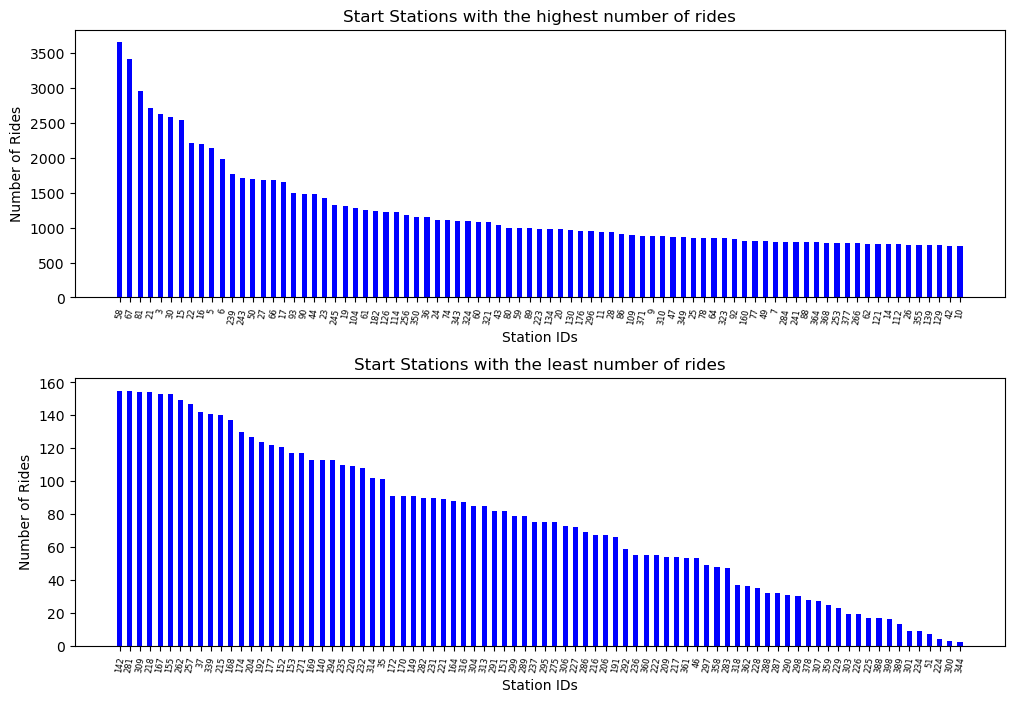

In [12]:
# Plotting the GoBike Stations with the highest ride starts(Top 7) and GoBike Stations with the least ride starts(Bottom 7)

plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace = 0.3)

plt.subplot(2,1,1)
plt.bar(x=gobike_most_station_start['index'], height=gobike_most_station_start['counts'], color='blue', width=0.5)
plt.xticks(fontsize=6, rotation=80)
plt.title('Start Stations with the highest number of rides')
plt.xlabel('Station IDs')
plt.ylabel('Number of Rides')

plt.subplot(2,1,2)
plt.bar(x=gobike_least_station_start['index'], height=gobike_least_station_start['counts'], color='blue', width=0.5)
plt.xticks(fontsize=6, rotation=80)
plt.title('Start Stations with the least number of rides')
plt.xlabel('Station IDs')
plt.ylabel('Number of Rides')

plt.show()


#### Filtering records from the Top7 and Bottom7 into a new data frame using their Station ID's

In [13]:
# Filtering records from only the Top 7 Stations with the most number of rides and saving into a new dataframe.
gobike_top7 = pd.DataFrame()

station_highest = ['58','67','81','21','3','30','15']
for i in station_highest:
    gobike_top7_2 = gobike.loc[gobike['start_station_id'] == i]
    gobike_top7 = pd.concat([gobike_top7,gobike_top7_2])

In [14]:
gobike_bottom7 = pd.DataFrame()

station_lowest = ['344','300','224','51','234','301','389']
for i in station_lowest:
    gobike_bottom7_2 = gobike.loc[gobike['start_station_id'] == i]
    gobike_bottom7 = pd.concat([gobike_bottom7,gobike_bottom7_2])

#### Plotting the coordinates of the Top 7 and Bottom 7 Stations on San Francisco Bay Area Map

In [15]:
# Filtering all duplicated start station id's so the dataframe is reduced according to the unique station ids with the MOST number of rides
gobike_top7_map = gobike_top7.drop_duplicates(subset = ['start_station_id'])

In [16]:
# Filtering all duplicated start station id's so the dataframe is reduced according to the unique station ids with the LEAST number of rides
gobike_bottom7_map = gobike_bottom7.drop_duplicates(subset = ['start_station_id'])

In [17]:
# Creating GeoPandas GeoDataFrame which has the 'plottable' coordinates derived from the latitudes and longitudes added as the last column (geometry)
gobike_top7_gdf = gpd.GeoDataFrame(gobike_top7_map, geometry = gpd.points_from_xy(gobike_top7_map['start_station_longitude'],gobike_top7_map['start_station_latitude']))
gobike_bottom7_gdf = gpd.GeoDataFrame(gobike_bottom7_map, geometry = gpd.points_from_xy(gobike_bottom7_map['start_station_longitude'],gobike_bottom7_map['start_station_latitude']))

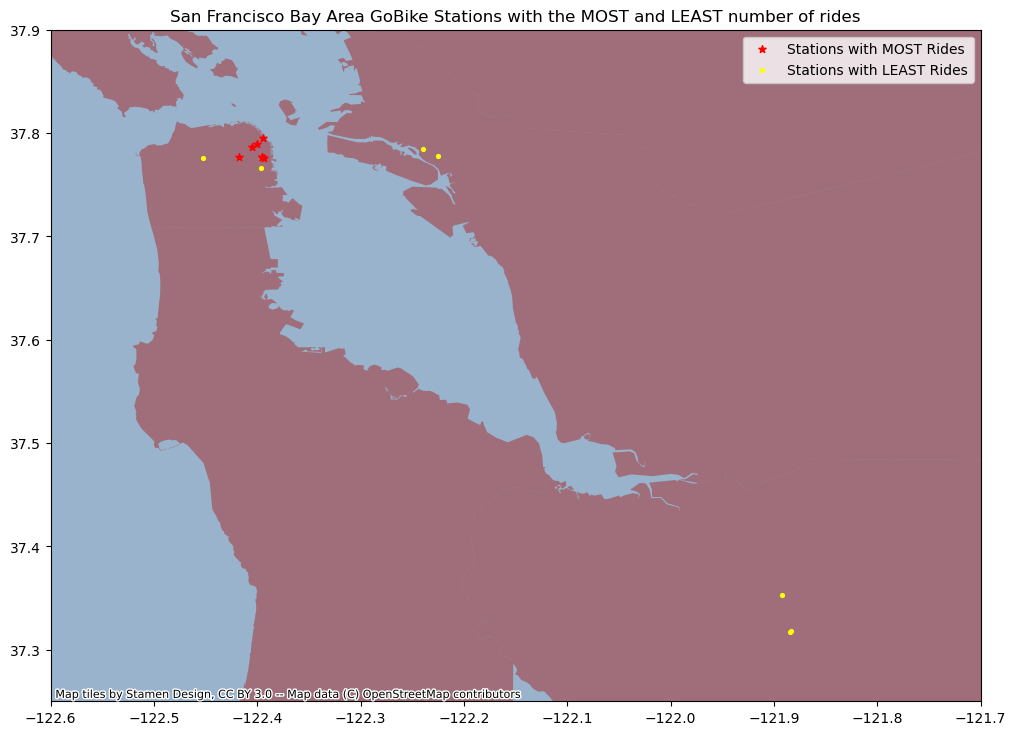

In [18]:
# Plotting the San Francisco Bay Area GoBike Stations with MOST rides and LEAST rides on a map (shapefile)

#Reading map file with geopandas
san_francisco_bay_map = gpd.read_file('map/bayarea_county.shp')

#Creating subplots and placing 3 plots on one another (Bay Area Map, Coordinates of Top 7 Stations and Coordinates of Bottom 7 Stations)
fig,ax = plt.subplots(figsize = (12,12))
san_francisco_bay_map.to_crs(epsg=4326).plot(ax=ax, alpha=0.5, color = 'brown')
gobike_top7_gdf.plot(ax = ax, markersize = 30, color = 'red', marker = '*')
gobike_bottom7_gdf.plot(ax = ax, markersize = 30, color = 'yellow',marker = '.')

cx.add_basemap(ax)
ax.set_xlim([-122.6, -121.7])
ax.set_ylim([37.25, 37.9])

ax.set_title('San Francisco Bay Area GoBike Stations with the MOST and LEAST number of rides')
plt.legend(['Stations with MOST Rides', 'Stations with LEAST Rides'])

plt.show()

## Categorical Values associated with Top 7 and Bottom 7 Stations

The 3 Categorical columns are User Type (Subscriber or Customer), Member Gender (Male, Female, Other), Bike Share For All (Yes, No).
I intend to see how these are distributed among the top 7 and Bottom 7 Stations.
This will be plotted in subplots for easy comparison

INSIGHT: For the Top 7 Stations, the charts are very skewed. Males dominated the number of rides as well as those without the Bike Share For All discount 
But for the Bottom 7 Stations, these charts varied slightly, the Females in some stations were almost equal to the Males. One other station had more Bike Share for All discount users.

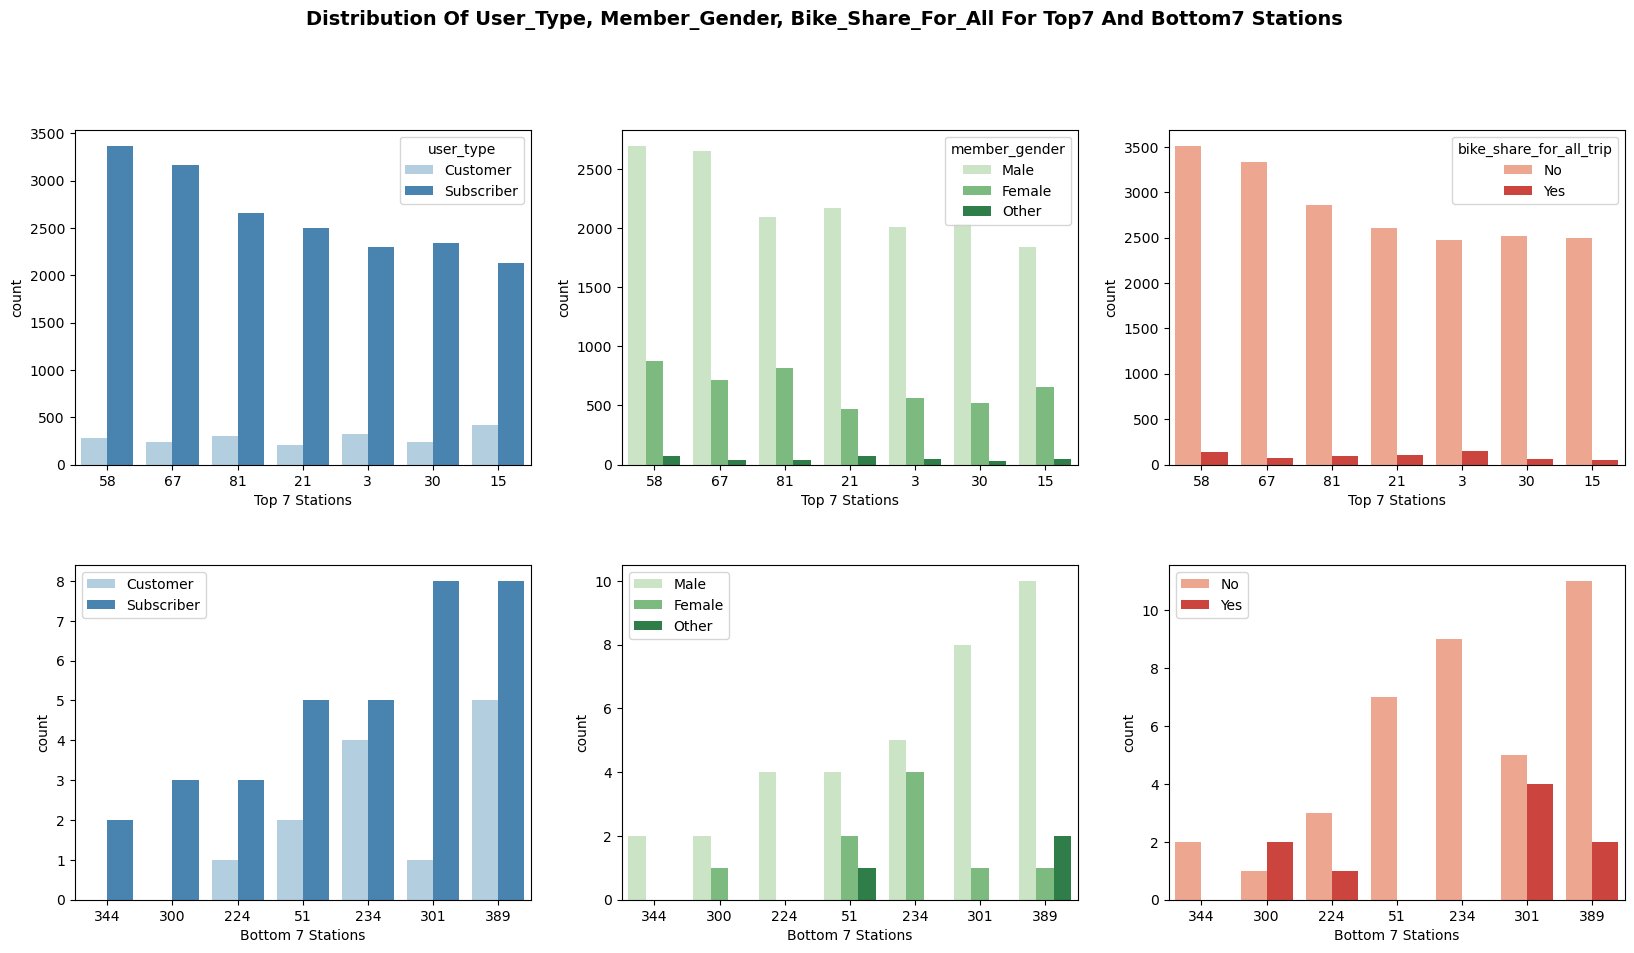

In [19]:
# Plotting the relationship between the user_type, member_gender and bike_share_for_all for each of the Top 7 and Bottom 7 Stations
# Top 7 on the Upper row and Bottom 7 on the Lower row
plt.figure(figsize = [20,10])
plt.subplots_adjust(hspace =0.3)

#subplot1: 
plt.subplot(2,3,1)
sb.countplot(data = gobike_top7, x = 'start_station_id', hue='user_type', palette = 'Blues')
plt.xticks()
plt.xlabel('Top 7 Stations')

#subplot2:
plt.subplot(2,3,2)
sb.countplot(data = gobike_top7, x = 'start_station_id', hue='member_gender', palette = 'Greens')
plt.xticks()
plt.xlabel('Top 7 Stations')

#subplot3:
plt.subplot(2,3,3)
sb.countplot(data = gobike_top7, x = 'start_station_id', hue='bike_share_for_all_trip', palette = 'Reds')
plt.xticks()
plt.xlabel('Top 7 Stations')

#subplot4: 
plt.subplot(2,3,4)
sb.countplot(data = gobike_bottom7, x = 'start_station_id', hue='user_type', palette = 'Blues')
plt.xticks()
plt.legend(loc = "upper left")
plt.xlabel('Bottom 7 Stations')

#subplot5:
plt.subplot(2,3,5)
sb.countplot(data = gobike_bottom7, x = 'start_station_id', hue='member_gender', palette = 'Greens')
plt.xticks()
plt.legend(loc = "upper left")
plt.xlabel('Bottom 7 Stations')

#subplot6:
plt.subplot(2,3,6)
sb.countplot(data = gobike_bottom7, x = 'start_station_id', hue='bike_share_for_all_trip', palette = 'Reds')
plt.xticks()
plt.legend(loc = "upper left")
plt.xlabel('Bottom 7 Stations')

plt.suptitle("Distribution of User_type, Member_gender, Bike_Share_For_All for Top7 and Bottom7 Stations".title(), y = 1,fontsize = 14, weight = "bold")

plt.show();

In [ ]:
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt